## Lab 2. Simple text processing and gradient boosting.
This lab assigments consists of two parts:

1. Simple text classification using Bag of Words and TF-IDF.
2. Human activity classification using gradient boosting.

These tasks are independent.

_We recommend to keep the datasets on your computer because they will be used in Lab 3 as well._

Deadline: May 5th, 23:59

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Part I: Prohibited Comment Classification (2 points)
This part of assigment is fully based on YSDA NLP_course homework. Special thanks to YSDA team for making it available on github.

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this part__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [72]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \r\n\r\nI am sorry, but you se..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\r\n\r\nCheck out the Wikipedia:...


In [73]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [74]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [75]:
# task: preprocess each comment in train and test

for i in range (texts_train.size):
    texts_train[i] = preprocess(texts_train[i])
    
for i in range (texts_train.size):
    texts_test[i] = preprocess(texts_test[i])

In [76]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [91]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)

k = min(10000, len(set(' '.join(texts_train).split())))

words = []

for i in range (texts_train.size):
    s = texts_train[i].split()
    for j in range (len(s)):
        words.append(s[j])

words = np.array(words)  

unique_words, word_counts = np.unique(words, return_counts = True)

number_of_classes = len(np.unique(words))
unique_words = np.array(unique_words)
sorted_unique_words = unique_words[np.argsort(word_counts)]

# рассматриваем k самых популярных слов (были в конце), и переворачиваем (боле частые теперь в начале)
bow_vocabulary = list(sorted_unique_words[-k:])[::-1]

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', 'ீ']


Сопоставим уникальным словам уникальные коды.

In [92]:
bow_vocab_dict = {}

for i in range(len(bow_vocabulary)):
    element = {bow_vocabulary[i] : i}
    bow_vocab_dict.update(element)

In [93]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    
    token_counts = np.zeros(len(bow_vocabulary))
    text_words = text.split()
    
    for i in range (len(text_words)):
        if (text_words[i] in bow_vocab_dict.keys()):
            word_index = bow_vocab_dict[text_words[i]]
            token_counts[word_index] += 1

    return np.array(token_counts, 'float32')

In [94]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [95]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Machine learning stuff: fit, predict, evaluate. You know the drill.

In [96]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression(solver = 'lbfgs').fit(X_train_bow, y_train)

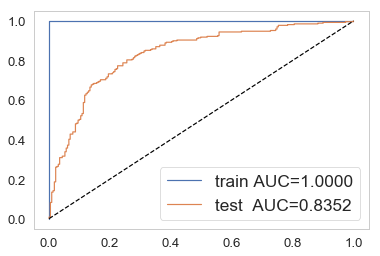

In [97]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

Функция, котоаря находит $k$ наиболее часто встречающихся:

In [98]:
def popular_words(k):
    k_bow_vocabulary = list(sorted_unique_words)
    l = len(k_bow_vocabulary)
    k_bow_vocabulary = k_bow_vocabulary[int(l-k):int(l)]
    return k_bow_vocabulary

Сопоставляем уникальным значениям уникальные коды:

In [99]:
def get_k_bow_vocab_dict(k):
    k_bow_vocab_dict = {}
    k_bow_vocabulary = popular_words(k)
    
    for i in range(len(k_bow_vocabulary)):
        element = {k_bow_vocabulary[i] : i}
        k_bow_vocab_dict.update(element)
    
    return k_bow_vocab_dict

Функция, аналогичная той, что была в первой части:

In [100]:
def k_text_to_bow(text, k):
    """ convert text string to an array of token counts."""

    k_bow_vocabulary = popular_words(k)
    token_counts = np.zeros(len(k_bow_vocabulary))
    text_words = text.split()
    
    k_bow_vocab_dict = get_k_bow_vocab_dict(k)
    
    for i in range (len(text_words)):
        if (text_words[i] in k_bow_vocab_dict.keys()):
            
            word_index = k_bow_vocab_dict[text_words[i]]
            token_counts[word_index] += 1

    return np.array(token_counts, 'float32')

Теперь меняем значения $k$ и смотрим на результат:

In [101]:
token_numbers = np.arange(100, 5800, 100)
auc_results = np.zeros(len(token_numbers))
auc_results = []

for k in token_numbers:
    k_nums = np.ones(texts_train.shape[0]) * k
    X_train_bow_k = np.stack(list(map(k_text_to_bow, texts_train, k_nums)))
    X_test_bow_k = np.stack(list(map(k_text_to_bow, texts_test, k_nums)))
    k_bow_model = LogisticRegression(solver = 'lbfgs', max_iter = 10000).fit(X_train_bow_k, y_train)
    proba = k_bow_model.predict_proba(X_test_bow_k)[:, 1]
    auc = roc_auc_score(y, proba)
    auc_results.append(auc)
    
    #выведем значения для некоторых k, чтобы оценить результат
    if (k % 400 == 0):
        print(k, " tokens : ", auc)

400  tokens :  0.8102640853570221
800  tokens :  0.8241201178004152
1200  tokens :  0.8315872479441253
1600  tokens :  0.8314906902267497
2000  tokens :  0.8310400875456637
2400  tokens :  0.8324240814947135
2800  tokens :  0.8328264053171116
3200  tokens :  0.8332287291395098
3600  tokens :  0.8334057516213651
4000  tokens :  0.8348058385233106
4400  tokens :  0.8338161219202114
4800  tokens :  0.8359564846553694
5200  tokens :  0.8358116480793061
5600  tokens :  0.8352966735866363


Нарисуем график:

In [102]:
import seaborn as sns

sns.set(context = 'paper', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.5,
 color_codes=False, rc=None)

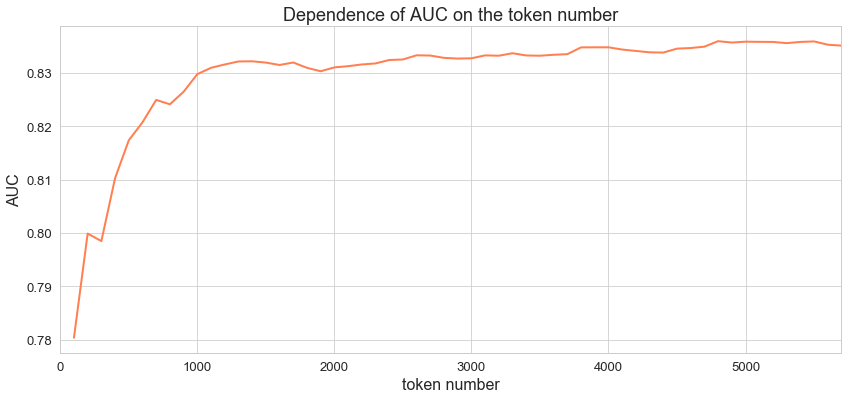

In [103]:
plt.figure(figsize=(14, 6))

plt.plot(token_numbers, auc_results, color='coral', lw=2)
    
plt.xlim([0, 5700])
plt.xlabel('token number', fontsize = 16)
plt.ylabel('AUC', fontsize = 16)
plt.title('Dependence of AUC on the token number', fontsize = 18)
plt.show()

#### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [104]:
# Your beautiful code here

Считаем, сколько раз каждое уникальное слово встретилось во всех документах:

In [117]:
#number of each word in all the documents
words_counts = np.zeros((len(bow_vocabulary)))

for i in range(texts_train.shape[0]):
    
    text_words = np.unique(texts_train[i].split())
    
    for j in range (len(text_words)):
        word_index = bow_vocab_dict[text_words[j]]
        words_counts[word_index] += 1

Применяем формулу, написанную выше:

In [118]:
alpha = 1
N = texts_train.shape[0]

def text_to_tfidf(text):
    """ convert text string to tfidf form """
    
    text_words = text.split()
    words_in_text = text_to_bow(text)
    
    text_tfidf = (words_in_text / len(text_words)) * np.log(N / (alpha + words_counts))

    return np.array(text_tfidf, 'float32')

In [119]:
X_train_tfidf = np.stack(list(map(text_to_tfidf, texts_train)))
X_test_tfidf = np.stack(list(map(text_to_tfidf, texts_test)))

In [120]:
tfidf_model = LogisticRegression(solver = 'lbfgs').fit(X_train_tfidf, y_train)

Полученный результат:

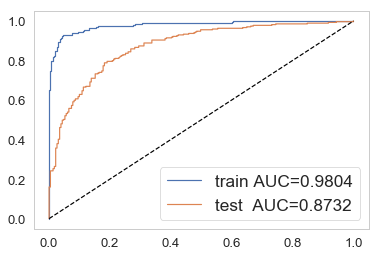

In [123]:
for name, X, y, model in [
    ('train', X_train_tfidf, y_train, tfidf_model),
    ('test ', X_test_tfidf, y_test, tfidf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Итак, в первом случае у нас получилось:
<br> test AUC = 0.8352

Во втором случае(с использованием TF-IDF):
<br> test AUC = 0.8732

Как можно заметить, второй результат оказался лучше первого, однако разница между ними не такая уж и большая. В то же время во втором случае (с использованием TF-IDF) результат мы получили довольно быстро. Значит, можно предположить, что использование TF-IDF будет полезным, потому что времени занимает не очень много, а результат при том улучшается (пусть и не очень сильно).

В целом, мы уже получили хороший результат, но еще на всякий случай добавим нормализацию. 

Итак, функция для нормализации (здесь const - небольшая константа, которую будем прибавлять в знаменателе, чтобы он получился ненулевой):

In [124]:
const = 1e-7

def normalize_text(text):
    normed_text = text / (np.linalg.norm(text) + const)
    return normed_text

Нормализуем данные:

In [125]:
X_train_tfidf_normed = np.stack(list(map(normalize_text, X_train_tfidf)))
X_test_tfidf_normed = np.stack(list(map(normalize_text, X_test_tfidf)))

Строим график:

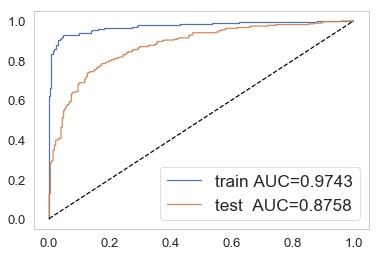

In [126]:
for name, X, y, model in [
    ('train', X_train_tfidf_normed, y_train, tfidf_model),
    ('test ', X_test_tfidf_normed, y_test, tfidf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Как можно заметить, результат на тестовой стал немного лучше (но все равно не сильно изменился). Таким образом, нормализация позволила немного улучшить результат.

### Part 2: gradient boosting (4 points)

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

First you are required to choose one of the main gradient boosting frameworks:
1. LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). One of the most popular frameworks these days that shows both great quality and performance.
2. xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
3. Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features. It's quite new, but if you wish to use it - you are welcome.

Some simple preprocessing is done for you. 

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 85% accuracy on test dataset.

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [27]:
X_train = np.genfromtxt('data/train/X_train.txt')
y_train = np.genfromtxt('data/train/y_train.txt')

X_test = np.genfromtxt('data/test/X_test.txt')
y_test = np.genfromtxt('data/test/y_test.txt')

with open('data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [28]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [29]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [30]:
unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [31]:
pca = PCA(0.99)

In [32]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [33]:
X_train_pca.shape

(7352, 179)

In [34]:
X_test_pca.shape

(2947, 179)

Text(0, 0.5, 'Principal component 2')

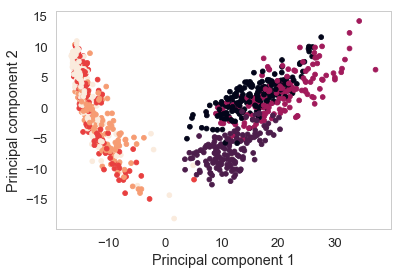

In [35]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 5')

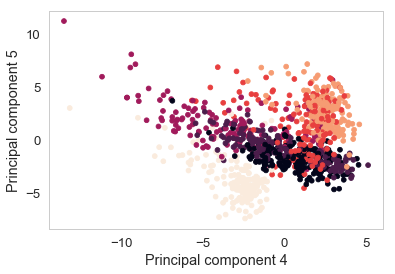

In [36]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

In [ ]:
# Your code here.
### Example: https://rpubs.com/burakh/har_xgb

Выбран был вариант №2: xgboost

In [37]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

Отдельно выпишем параметры, которые будем рассматривать. Поскольку работает GridSearch очень долго, в большинстве случаев я буду просто каждый раз добавлять по одному параметру для поиска, фиксируя те, что были отобраны ранее. (Но в одном случае все равно для проверки сделяю поиск по двум параметрам). Итак, какие параметры будем рассматривать:

In [41]:
n_estimators_param = [100, 200, 300, 400, 500]
max_depth_param = np.arange(1, 5)
subsample_param = [0.6, 0.8, 1]

#params = {'n_estimators': n_estimators_param, 'max_depth': max_depth, 'subsample': subsample_param}
params_1 = {'booster__n_estimators': n_estimators_param}
params_2 = {'booster__max_depth': max_depth_param}
params_12 = {'booster__n_estimators': n_estimators_param, 'booster__max_depth': max_depth_param}

Итак, рассмотрим классификатор (плюс, не забываем про pipeline):

In [42]:
xgbc = xgb.XGBClassifier(objective = 'multi::softmax', verbosity = 3, njobs = 8)
pipe = Pipeline(memory = None, steps = [("scaler", MinMaxScaler()), ("booster", xgbc)])

1. Для начала рассмотрим "n_estimators":

In [43]:
gs_1 = GridSearchCV(pipe, params_1, cv=3, scoring='accuracy')
gs_1.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('booster', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, mis...pha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbosity=3))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'booster__n_estimators': [100, 200, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Получаем результат:

In [44]:
print("best_params: {}, best_score: {}".format(gs_1.best_params_, gs_1.best_score_))

best_params: {'booster__n_estimators': 500}, best_score: 0.9246463547334058


2. Теперь рассмотрим "max_depth":

In [45]:
params_2 = {'booster__n_estimators': [500], 'booster__max_depth': max_depth_param}

In [46]:
gs_2 = GridSearchCV(pipe, params_2, cv = 3, scoring = 'accuracy')
gs_2.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('booster', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, mis...pha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbosity=3))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'booster__n_estimators': [500], 'booster__max_depth': array([1, 2, 3, 4])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Получаем результат:

In [47]:
print("best_params: {}, best_score: {}".format(gs_2.best_params_, gs_2.best_score_))

best_params: {'booster__max_depth': 2, 'booster__n_estimators': 500}, best_score: 0.9279107725788901


3. Теперь рассмотрим на всякий случай одновременно "max_depth" и "n_estimators":

In [65]:
gs_12 = GridSearchCV(pipe, params_12, cv = 3, scoring = 'accuracy')
gs_12.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('booster', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, mis...pha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbosity=3))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'booster__n_estimators': [100, 200, 300, 400, 500], 'booster__max_depth': array([1, 2, 3, 4])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Получаем результат:

In [66]:
print("best_params: {}, best_score: {}".format(gs_12.best_params_, gs_12.best_score_))

best_params: {'booster__max_depth': 2, 'booster__n_estimators': 400}, best_score: 0.9281828073993471


Как мы видим, результат получился чуть лучше, чем когда мы рассматривали каждый из этих двух параметров отдельно, но все же разница между результатами очень маленькая (порядка 0.0003), поэтому для дальнейшей работы возьмем любой из получившихся результатов ("max_depth" в обоих случаях вышел одинаковый, отличается только "n_estimators").

Итак, положим все же $n$_$estimators = 500$, $max$ _$depth = 2$, как было получено при поочередном подробе параметров.

4. Теперь рассмотрим "learning_rate":

In [50]:
params_3 = {'booster__n_estimators': [500], 'booster__max_depth': [2], 'booster__learning_rate': np.linspace(0.1, 1, 10)}

In [51]:
gs_3 = GridSearchCV(pipe, params_3, cv = 3, scoring = 'accuracy')
gs_3.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('booster', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, mis...pha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbosity=3))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'booster__n_estimators': [500], 'booster__max_depth': [2], 'booster__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Получаем результат:

In [55]:
print("best_params: {}".format(gs_3.best_params_))
print("best_score: {}".format(gs_3.best_score_))

best_params: {'booster__learning_rate': 0.2, 'booster__max_depth': 2, 'booster__n_estimators': 500}
best_score: 0.9303590859630033


Запустим теперь с выбранными параметрами:

In [56]:
xgbc_optimal = xgb.XGBClassifier(objective = 'multi::softmax', verbosity = 3, njobs = 8, 
                                 n_estimators = 500, max_depth = 2, learning_rate = 0.2)

In [57]:
xgbc_optimal.fit(X_train, y_train)
y_optimal_pred = xgbc_optimal.predict(X_test)

print( "accuracy: ", accuracy_score(y_test, y_optimal_pred))

accuracy:  0.9548693586698337


Как можно заметить, результат уже получился довольно хороший (больше 0.85, как и требовалось). В прицнипе, можно попробовать варьировать и остальные параметры. Например, можно посмотреть на параметр "gamma":

In [59]:
params_gamma = np.linspace(0, 1, 5)

params_4 = {'booster__n_estimators': [500], 'booster__max_depth': [2], 
            'booster__learning_rate': [0.2], 'booster__gamma': params_gamma}

In [60]:
gs_4 = GridSearchCV(pipe, params_4, cv = 3, scoring = 'accuracy')
gs_4.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('booster', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, mis...pha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbosity=3))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'booster__n_estimators': [500], 'booster__max_depth': [2], 'booster__learning_rate': [0.2], 'booster__gamma': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Получаем результат:

In [61]:
print("best_params: {}".format(gs_4.best_params_))
print("best_score: {}".format(gs_4.best_score_))

best_params: {'booster__gamma': 0.0, 'booster__learning_rate': 0.2, 'booster__max_depth': 2, 'booster__n_estimators': 500}
best_score: 0.9303590859630033


Результат получился такой же (потому что у нас вышло, что gamma=0, а оно таким и было), зато мы убедились, что лучше (по крайней мере, при выбранных значениях параметра "gamma") получиться не могло.

Итак, в результате имеем:

In [63]:
xgbc_optimal_2 = xgb.XGBClassifier(objective = 'multi::softmax', njobs = 8, 
                                 n_estimators = 500, max_depth = 2, learning_rate = 0.2, gamma = 0)

In [64]:
xgbc_optimal_2.fit(X_train, y_train)
y_optimal_pred_2 = xgbc_optimal_2.predict(X_test)

print( "accuracy: ", accuracy_score(y_test, y_optimal_pred_2))

accuracy:  0.9548693586698337


В заключение, стоит сказать, что точность (accuracy) получилась довольно хорошая (0.955), но работает это все очень долго. В целом, если время работы алгоритма не играет много роли, то с помощью данного классификатора можно получить неплохой результат.